# Marketing Insights for E-Commerce Company Customer Level Data Segmentation

In [80]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations,combinations
from collections import Counter

#Import packages for clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#Center and scale the data
from sklearn.preprocessing import StandardScaler

#Statsmodel and Sklearn Packages for Classification Model
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import RFE,SelectKBest,f_classif
from sklearn.linear_model import LogisticRegression
from xgboost import  XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded=files.upload()

Saving CustomersData.xlsx to CustomersData.xlsx
Saving Discount_Coupon.csv to Discount_Coupon.csv
Saving Marketing_Spend.csv to Marketing_Spend.csv
Saving Online_Sales.csv to Online_Sales.csv
Saving Tax_amount.xlsx to Tax_amount.xlsx


In [3]:
cust_data=pd.read_excel('CustomersData.xlsx')
cust_data

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49
...,...,...,...,...
1463,14438,F,New York,41
1464,12956,F,Chicago,48
1465,15781,M,New Jersey,19
1466,14410,F,New York,45


In [4]:
dis_coup=pd.read_csv('Discount_Coupon.csv')
dis_coup

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20
...,...,...,...,...
199,Nov,Notebooks & Journals,NJ20,20
200,Dec,Notebooks & Journals,NJ30,30
201,Oct,Android,AND10,10
202,Nov,Android,AND20,20


In [5]:
dis_coup.columns=['Month', 'Product_Category', 'Coupon_Code', 'Discount_pct']

#Changing Month names to Numeical Number of Month!
dis_coup.Month=pd.to_datetime(dis_coup.Month, format='%b').dt.month

In [6]:
on_sales=pd.read_csv('Online_Sales.csv')
on_sales

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
1,17850,16680,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
2,17850,16681,20190101,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used
3,17850,16682,20190101,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used
4,17850,16682,20190101,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used
...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,20191231,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked
52920,14410,48494,20191231,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used
52921,14410,48495,20191231,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used
52922,14600,48496,20191231,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked


In [7]:
tax=pd.read_excel('Tax_amount.xlsx')
tax

,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18
5,Lifestyle,0.18
6,Notebooks & Journals,0.05
7,Headgear,0.05
8,Waze,0.18
9,Fun,0.18


### Data Preparation for Customer Level Aggregated Data

In [8]:
cust_sales=pd.merge(left=on_sales,right=cust_data,how='inner',on='CustomerID')

In [9]:
#Extracting Month Number from Transaction Date!
cust_sales['Month']=pd.to_datetime(cust_sales.Transaction_Date,format='%Y%m%d').dt.month

In [10]:
cust_sales_tax=pd.merge(left=cust_sales,right=tax,how='inner',on='Product_Category')

In [11]:
df_final=pd.merge(left=cust_sales_tax,right=dis_coup,how='left',on=['Product_Category','Month'])
df_final

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,Month,GST,Coupon_Code,Discount_pct
0,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,M,Chicago,12,1,0.10,ELEC10,10.0
1,17850,16680,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,M,Chicago,12,1,0.10,ELEC10,10.0
2,17850,16696,20190101,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.50,Not Used,M,Chicago,12,1,0.10,ELEC10,10.0
3,17850,16699,20190101,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,1,81.50,6.50,Clicked,M,Chicago,12,1,0.10,ELEC10,10.0
4,17850,16700,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Clicked,M,Chicago,12,1,0.10,ELEC10,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14159,27255,20190504,GGOEGBMB073599,Google Collapsible Duffel Black,More Bags,5,17.59,18.12,Clicked,F,California,13,5,0.18,NaN,NaN
52920,14577,27280,20190504,GGOEGBMB073599,Google Collapsible Duffel Black,More Bags,1,17.59,6.00,Not Used,M,California,36,5,0.18,NaN,NaN
52921,17890,28366,20190519,GGOEGBMB073599,Google Collapsible Duffel Black,More Bags,1,21.99,6.00,Used,F,Chicago,27,5,0.18,NaN,NaN
52922,16442,28662,20190522,GGOEGBMB073599,Google Collapsible Duffel Black,More Bags,1,17.59,51.99,Used,F,New York,46,5,0.18,NaN,NaN


In [12]:
df_final.Discount_pct.fillna(0, inplace=True)

In [13]:
df_final['Invoice_Value']=((df_final.Quantity*df_final.Avg_Price) *
                          (1-(df_final.Discount_pct/100))*(1+df_final.GST)) + df_final.Delivery_Charges
df_final.Invoice_Value

0        158.6729
1        158.6729
2        249.5846
3         87.1850
4        158.6729
           ...   
52919    121.9010
52920     26.7562
52921     31.9482
52922     72.7462
52923     31.9482
Name: Invoice_Value, Length: 52924, dtype: float64

In [14]:
df_final['Revenue']=((df_final.Quantity*df_final.Avg_Price)
                    * (1-(df_final.Discount_pct/100)))
df_final.Revenue

0        138.339
1        138.339
2        220.986
3         73.350
4        138.339
          ...   
52919     87.950
52920     17.590
52921     21.990
52922     17.590
52923     21.990
Name: Revenue, Length: 52924, dtype: float64

In [15]:
df_final.Transaction_Date=pd.to_datetime(df_final.Transaction_Date,format='%Y%m%d')

### Customer Aggregation Data

In [16]:
quantity_purchased=df_final.groupby('CustomerID')['Quantity'].sum()

In [17]:
no_of_transactions=df_final.groupby('CustomerID')['Transaction_ID'].count()

In [18]:
avg_delivery_charges=df_final.groupby('CustomerID')['Delivery_Charges'].sum()

In [19]:
revenue_monetary=df_final.groupby('CustomerID')['Revenue'].sum()

In [20]:
cust_data1=pd.concat([no_of_transactions,quantity_purchased,avg_delivery_charges,revenue_monetary],axis=1)
cust_data1.columns=['no_of_transactions','quantity_purchased','avg_deliver_charges','revenue_monetary']

In [21]:
cust_data2=pd.merge(left=cust_data,right=cust_data1,on='CustomerID',how='inner')
cust_data2

,CustomerID,Gender,Location,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary
0,17850,M,Chicago,12,297,1133,3162.62,31110.858
1,13047,M,California,43,44,175,315.96,2321.227
2,12583,M,Chicago,33,42,155,757.27,1971.352
3,13748,F,California,30,1,1,6.50,1.116
4,15100,M,California,49,6,15,64.38,762.752
...,...,...,...,...,...,...,...,...
1463,14438,F,New York,41,9,29,55.50,354.816
1464,12956,F,Chicago,48,19,35,135.99,2101.407
1465,15781,M,New Jersey,19,5,10,32.50,514.703
1466,14410,F,New York,45,8,11,52.00,776.293


### 3.Performing Customer Segmentation

a] Heuristic(Value based,RFM) - Divide the customers into Premium, Gold, Silver, Standard Customers and Define strategy on the same.

In [ ]:
#Value Based Segment!
cust_data2['revenue_monetary'].quantile([.25,.5,0.75])

0.25     512.150
0.50    1407.212
0.75    3164.615
Name: revenue_monetary, dtype: float64

In [ ]:
value_seg=cust_data2.copy()

In [ ]:
value_seg['Value_based_segments']=np.where(value_seg.revenue_monetary<512.15, 'Standard', np.where(value_seg.revenue_monetary<1407.21,'Silver', 
                                                            np.where(value_seg.revenue_monetary<3164.61,'Gold','Premium') ))
value_seg

,CustomerID,Gender,Location,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,Value_based_segments
0,17850,M,Chicago,12,297,1133,3162.62,31110.858,Premium
1,13047,M,California,43,44,175,315.96,2321.227,Gold
2,12583,M,Chicago,33,42,155,757.27,1971.352,Gold
3,13748,F,California,30,1,1,6.50,1.116,Standard
4,15100,M,California,49,6,15,64.38,762.752,Silver
...,...,...,...,...,...,...,...,...,...
1463,14438,F,New York,41,9,29,55.50,354.816,Standard
1464,12956,F,Chicago,48,19,35,135.99,2101.407,Gold
1465,15781,M,New Jersey,19,5,10,32.50,514.703,Silver
1466,14410,F,New York,45,8,11,52.00,776.293,Silver


In [ ]:
#Value Based Profiling!
value_seg.groupby('Value_based_segments')[['Tenure_Months','no_of_transactions','quantity_purchased','avg_deliver_charges','revenue_monetary']].agg(np.mean)

,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary
Value_based_segments,,,,,
Gold,26.493188,32.043597,138.643052,314.186349,2131.042144
Premium,25.365123,89.354223,430.716621,953.301580,6946.784853
Silver,26.392371,16.457766,60.261580,193.313188,910.826120
Standard,25.397820,6.351499,18.970027,55.915695,215.260717


#### RFM Segmentation

In [ ]:
#Last Date of Transaction!
last_date_transaction=df_final.Transaction_Date.max()

In [ ]:
#Last date of Transaction Per Customer!
last_transaction_cust=df_final.groupby('CustomerID')['Transaction_Date'].max()

In [ ]:
#Recency Calculation!
recency1=last_date_transaction-last_transaction_cust

In [ ]:
#To remove days from frequency values and converting it to Integer!
recency=(recency1 / np.timedelta64(1, 'D')).astype(int)

In [ ]:
rfm=cust_data2.copy()

In [ ]:
#Changing column name from no_of_transactions to Frequency for clear understanding!
rfm=rfm.rename(columns = {'no_of_transactions':'frequency'})

In [ ]:
rfm_final=pd.merge(left=rfm,right=recency,how='inner',on='CustomerID')

In [ ]:
rfm_final=rfm_final.rename(columns = {'Transaction_Date':'recency'})

In [ ]:
rfm_final

,CustomerID,Gender,Location,Tenure_Months,frequency,quantity_purchased,avg_deliver_charges,revenue_monetary,recency
0,17850,M,Chicago,12,297,1133,3162.62,31110.858,339
1,13047,M,California,43,44,175,315.96,2321.227,13
2,12583,M,Chicago,33,42,155,757.27,1971.352,151
3,13748,F,California,30,1,1,6.50,1.116,364
4,15100,M,California,49,6,15,64.38,762.752,123
...,...,...,...,...,...,...,...,...,...
1463,14438,F,New York,41,9,29,55.50,354.816,0
1464,12956,F,Chicago,48,19,35,135.99,2101.407,0
1465,15781,M,New Jersey,19,5,10,32.50,514.703,0
1466,14410,F,New York,45,8,11,52.00,776.293,0


In [ ]:
rfm_final[['frequency','revenue_monetary','recency' ]].quantile(q=[0.25,0.50,0.75])

,frequency,revenue_monetary,recency
0.25,10.0,512.150,55.0
0.50,21.0,1407.212,131.0
0.75,46.0,3164.615,220.0


In [ ]:
#Recency Segment!
rfm_final['r_seg'] = np.where(rfm_final.recency<=55, 'Active_cust', np.where(rfm_final.recency<=131, 'Moderate_Active',
                                                                np.where(rfm_final.recency<=220,'At_Risk','Churn')))

In [ ]:
#Monetary Segment!
rfm_final['m_seg'] = np.where(rfm_final.revenue_monetary<=512.15, 1, np.where(revenue_monetary<=1407.21,2, 
                                                             np.where(revenue_monetary<=3164.61,3,4)))

In [ ]:
#Frequency Segment!
rfm_final['f_seg'] = np.where(rfm_final.frequency<=10, 1, np.where(rfm_final.frequency<=21, 2,np.where(rfm_final.frequency<=46,3,4)))

In [ ]:
rfm_final

,CustomerID,Gender,Location,Tenure_Months,frequency,quantity_purchased,avg_deliver_charges,revenue_monetary,recency,r_seg,m_seg,f_seg
0,17850,M,Chicago,12,297,1133,3162.62,31110.858,339,Churn,2,4
1,13047,M,California,43,44,175,315.96,2321.227,13,Active_cust,4,3
2,12583,M,Chicago,33,42,155,757.27,1971.352,151,At_Risk,2,3
3,13748,F,California,30,1,1,6.50,1.116,364,Churn,1,1
4,15100,M,California,49,6,15,64.38,762.752,123,Moderate_Active,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1463,14438,F,New York,41,9,29,55.50,354.816,0,Active_cust,1,1
1464,12956,F,Chicago,48,19,35,135.99,2101.407,0,Active_cust,3,2
1465,15781,M,New Jersey,19,5,10,32.50,514.703,0,Active_cust,2,1
1466,14410,F,New York,45,8,11,52.00,776.293,0,Active_cust,2,1


In [ ]:
rfm_final['fm_seg'] = np.where(((rfm_final.f_seg == 4) & (rfm_final.m_seg ==4))|((rfm_final.f_seg == 4) & (rfm_final.m_seg ==3))|((rfm_final.f_seg == 3) & (rfm_final.m_seg ==4)),'Premium',
                          np.where((((rfm_final.f_seg == 3) & (rfm_final.m_seg ==3))|((rfm_final.f_seg == 3) & (rfm_final.m_seg ==2)) | ((rfm_final.f_seg == 2) & (rfm_final.m_seg ==3))) , 'Gold',
                          np.where((((rfm_final.f_seg == 1) & (rfm_final.m_seg ==3)) | ((rfm_final.f_seg == 3) & (rfm_final.m_seg ==1)) | ((rfm_final.f_seg == 2) & (rfm_final.m_seg ==2))), 'Silver', 'Standard' )))

In [ ]:
rfm_final[['recency', 'revenue_monetary', 'frequency','r_seg', 'fm_seg']].groupby(['r_seg', 'fm_seg']).mean()

recency  revenue_monetary  frequency
r_seg           fm_seg                                           
Active_cust     Gold       26.395604       2270.443154  28.252747
                Premium    26.539216       7060.438314  88.009804
                Silver     25.764706       1242.941294  15.647059
                Standard   24.140845       3710.818345  49.239437
At_Risk         Gold      177.448718       1737.483974  27.974359
                Premium   169.037037       3417.935204  60.203704
                Silver    168.512821       1068.988769  14.256410
                Standard  172.178947       1167.759547  22.178947
Churn           Gold      276.361111       1921.943528  28.208333
                Premium   287.816327       4118.954571  58.591837
                Silver    292.407407       1151.625667  14.240741
                Standard  291.801047       1223.015026  16.387435
Moderate_Active Gold       93.858824       2316.867094  30.470588
                Premium    90.226667       4348.013987  63.813333
                Silver     93.647059       1069.348118  14.529412
                Standard   93.814607       2639.455360  39.202247

In [ ]:
#Priority-1!
rfm_final[((rfm_final.r_seg=='Active_cust') & (rfm_final.fm_seg=='Premium'))]

,CustomerID,Gender,Location,Tenure_Months,frequency,quantity_purchased,avg_deliver_charges,revenue_monetary,recency,r_seg,m_seg,f_seg,fm_seg
1,13047,M,California,43,44,175,315.96,2321.227,13,Active_cust,4,3,Premium
6,14688,F,New York,46,58,124,390.46,6056.962,32,Active_cust,4,4,Premium
8,15311,F,Chicago,40,587,4211,4837.96,63732.347,12,Active_cust,4,4,Premium
9,14527,M,California,43,199,955,1825.04,12902.353,32,Active_cust,4,4,Premium
16,17511,F,Chicago,25,213,847,1930.15,13195.562,21,Active_cust,3,4,Premium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,17672,M,California,39,41,55,387.81,3414.782,13,Active_cust,4,3,Premium
1439,17507,F,California,25,45,57,443.69,4002.453,11,Active_cust,4,3,Premium
1442,13871,F,New York,17,23,33,227.92,2275.196,11,Active_cust,4,3,Premium
1450,13137,M,California,37,48,78,391.60,5196.744,9,Active_cust,4,4,Premium


In [ ]:
#Priority-2!
rfm_final[((rfm_final.r_seg=='Active_cust') & (rfm_final.fm_seg=='Gold'))]

,CustomerID,Gender,Location,Tenure_Months,frequency,quantity_purchased,avg_deliver_charges,revenue_monetary,recency,r_seg,m_seg,f_seg,fm_seg
15,12431,F,New Jersey,14,44,57,309.22,4689.918,40,Active_cust,3,3,Gold
50,12868,F,California,8,46,101,681.50,4477.644,49,Active_cust,2,3,Gold
99,15694,F,New York,41,24,85,231.03,2156.268,25,Active_cust,3,3,Gold
117,15658,M,Chicago,24,28,160,1582.61,3683.727,13,Active_cust,2,3,Gold
137,15738,M,New Jersey,16,37,88,493.01,1638.860,33,Active_cust,3,3,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,15090,F,Chicago,17,23,32,149.50,1785.056,5,Active_cust,3,3,Gold
1458,13911,M,Chicago,30,25,131,157.50,2177.147,4,Active_cust,2,3,Gold
1461,13584,M,Chicago,35,24,35,171.39,1994.615,2,Active_cust,3,3,Gold
1462,17105,F,New Jersey,38,38,64,243.00,3501.162,1,Active_cust,2,3,Gold


In [ ]:
#Priorty-3!
rfm_final[((rfm_final.r_seg=='Active_cust') & (rfm_final.fm_seg=='Silver'))]

,CustomerID,Gender,Location,Tenure_Months,frequency,quantity_purchased,avg_deliver_charges,revenue_monetary,recency,r_seg,m_seg,f_seg,fm_seg
145,14466,F,Chicago,18,17,23,123.99,1569.439,10,Active_cust,2,2,Silver
212,15240,M,New York,40,17,25,137.75,1622.260,27,Active_cust,2,2,Silver
278,16353,M,Washington DC,6,13,21,119.49,687.080,11,Active_cust,2,2,Silver
393,15602,F,New Jersey,10,17,20,219.68,1058.988,30,Active_cust,2,2,Silver
466,14744,F,California,31,14,136,91.48,1455.646,28,Active_cust,2,2,Silver
538,16717,F,New York,42,18,52,170.49,876.314,18,Active_cust,2,2,Silver
962,17389,F,New York,2,17,138,213.82,1991.332,28,Active_cust,2,2,Silver
1034,16748,M,Chicago,41,19,56,252.72,1351.704,12,Active_cust,2,2,Silver
1074,18095,F,Chicago,14,21,93,220.28,966.848,32,Active_cust,2,2,Silver
1093,15939,F,California,11,18,58,108.50,780.456,24,Active_cust,2,2,Silver


In [ ]:
#Priority-4!
rfm_final[((rfm_final.r_seg=='Active_cust') & (rfm_final.fm_seg=='Standard'))]

,CustomerID,Gender,Location,Tenure_Months,frequency,quantity_purchased,avg_deliver_charges,revenue_monetary,recency,r_seg,m_seg,f_seg,fm_seg
13,16029,F,Washington DC,40,52,142,676.62,4001.599,5,Active_cust,2,4,Standard
31,17920,F,California,18,105,939,815.56,9773.595,40,Active_cust,2,4,Standard
37,13694,F,California,44,104,152,779.89,4187.542,11,Active_cust,2,4,Standard
68,16456,M,California,47,62,264,593.95,6184.823,3,Active_cust,2,4,Standard
74,13093,M,California,35,143,612,1118.51,9213.177,19,Active_cust,2,4,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,14842,F,New Jersey,14,2,2,12.50,114.156,4,Active_cust,1,1,Standard
1463,14438,F,New York,41,9,29,55.50,354.816,0,Active_cust,1,1,Standard
1465,15781,M,New Jersey,19,5,10,32.50,514.703,0,Active_cust,2,1,Standard
1466,14410,F,New York,45,8,11,52.00,776.293,0,Active_cust,2,1,Standard


#### b] Scientific(Using K-Means) & Understand the profiles.Define strategy for each Segment.

In [ ]:
# Adding revenue per month as a column
revenue_per_month = pd.pivot_table(df_final, index='CustomerID', columns='Month', values='Revenue',aggfunc='sum')
revenue_per_month.columns = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
revenue_per_month = revenue_per_month.fillna(0)
revenue_per_month

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
CustomerID,,,,,,,,,,,,
12346,0.0,0.0,0.000,0.000,0.0,0.000,0.00,0.000,21.693,0.000,0.00,0.000
12347,0.0,0.0,7857.949,0.000,0.0,0.000,0.00,0.000,0.000,0.000,2095.08,0.000
12348,0.0,0.0,0.000,0.000,0.0,543.921,0.00,0.000,0.000,598.581,0.00,0.000
12350,0.0,0.0,0.000,0.000,0.0,0.000,0.00,0.000,0.000,0.000,0.00,952.049
12356,0.0,0.0,0.000,0.000,0.0,0.000,0.00,0.000,1009.729,0.000,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
18259,0.0,0.0,0.000,491.665,0.0,0.000,0.00,0.000,0.000,0.000,0.00,0.000
18260,0.0,0.0,0.000,0.000,0.0,874.370,0.00,700.912,0.000,224.559,0.00,0.000
18269,0.0,0.0,0.000,78.183,0.0,10.283,0.00,0.000,0.000,0.000,0.00,0.000


In [32]:
#Quantity by product_category
quantity_purchased=pd.pivot_table(df_final, index='CustomerID',columns='Product_Category', values='Quantity', aggfunc='sum')
quantity_purchased.fillna(0, inplace=True)
quantity_purchased

Product_Category,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,Gift Cards,Google,Headgear,Housewares,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze
CustomerID,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
12347,1.0,0.0,231.0,0.0,6.0,0.0,7.0,0.0,0.0,2.0,2.0,0.0,3.0,0.0,2.0,0.0,33.0,0.0,55.0,0.0
12348,0.0,0.0,4.0,0.0,61.0,0.0,76.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,5.0,0.0,54.0,0.0
12350,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0
12356,0.0,0.0,19.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,5.0,0.0,21.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18259,0.0,0.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0,0.0,0.0
18260,2.0,0.0,22.0,0.0,3.0,1.0,4.0,13.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,30.0,47.0,3.0
18269,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [ ]:
scientific_seg1=pd.merge(left=cust_data2,right=revenue_per_month,on='CustomerID',how='inner')

In [ ]:
scientific_seg_final=pd.merge(left=scientific_seg1,right=quantity_purchased,on='CustomerID',how='inner')
scientific_seg_final

,CustomerID,Gender,Location,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,Jan,Feb,...,Headgear,Housewares,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze
0,17850,M,Chicago,12,297,1133,3162.62,31110.858,31110.858,0.0,...,16.0,15.0,171.0,0.0,0.0,7.0,181.0,1.0,422.0,10.0
1,13047,M,California,43,44,175,315.96,2321.227,839.781,0.0,...,7.0,0.0,1.0,0.0,2.0,0.0,16.0,0.0,123.0,1.0
2,12583,M,Chicago,33,42,155,757.27,1971.352,739.512,0.0,...,1.0,3.0,1.0,0.0,0.0,0.0,10.0,26.0,4.0,0.0
3,13748,F,California,30,1,1,6.50,1.116,1.116,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15100,M,California,49,6,15,64.38,762.752,138.339,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,14438,F,New York,41,9,29,55.50,354.816,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,20.0,0.0
1464,12956,F,Chicago,48,19,35,135.99,2101.407,0.000,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,19.0,0.0,3.0,0.0
1465,15781,M,New Jersey,19,5,10,32.50,514.703,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
1466,14410,F,New York,45,8,11,52.00,776.293,0.000,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0


In [ ]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [ ]:
scientific_seg_final1=create_dummies(scientific_seg_final,['Gender','Location'])
scientific_seg_final1.set_index('CustomerID',inplace=True)

In [ ]:
scientific_seg_final1

,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,Jan,Feb,Mar,Apr,May,...,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC
CustomerID,,,,,,,,,,,,,,,,,,,,,
17850,12,297,1133,3162.62,31110.858,31110.858,0.0,0.000,0.0,0.0,...,7.0,181.0,1.0,422.0,10.0,1,1,0,0,0
13047,43,44,175,315.96,2321.227,839.781,0.0,0.000,0.0,0.0,...,0.0,16.0,0.0,123.0,1.0,1,0,0,0,0
12583,33,42,155,757.27,1971.352,739.512,0.0,0.000,0.0,0.0,...,0.0,10.0,26.0,4.0,0.0,1,1,0,0,0
13748,30,1,1,6.50,1.116,1.116,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
15100,49,6,15,64.38,762.752,138.339,0.0,91.665,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14438,41,9,29,55.50,354.816,0.000,0.0,0.000,0.0,0.0,...,0.0,4.0,0.0,20.0,0.0,0,0,0,1,0
12956,48,19,35,135.99,2101.407,0.000,0.0,0.000,0.0,0.0,...,0.0,19.0,0.0,3.0,0.0,0,1,0,0,0
15781,19,5,10,32.50,514.703,0.000,0.0,0.000,0.0,0.0,...,0.0,8.0,0.0,0.0,0.0,1,0,1,0,0


In [ ]:
#Outlier Treatment!
scientific_seg_final1=scientific_seg_final1.apply(lambda x: x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99)))
scientific_seg_final1

,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,Jan,Feb,Mar,Apr,May,...,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC
CustomerID,,,,,,,,,,,,,,,,,,,,,
17850,12,216.3,1133.0,2637.7716,16717.73694,4764.95397,0.0,0.000,0.0,0.0,...,5.0,95.33,1.0,422.0,10.0,1,1,0,0,0
13047,43,44.0,175.0,315.9600,2321.22700,839.78100,0.0,0.000,0.0,0.0,...,0.0,16.00,0.0,123.0,1.0,1,0,0,0,0
12583,33,42.0,155.0,757.2700,1971.35200,739.51200,0.0,0.000,0.0,0.0,...,0.0,10.00,26.0,4.0,0.0,1,1,0,0,0
13748,30,1.0,1.0,6.5000,9.05934,1.11600,0.0,0.000,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0
15100,49,6.0,15.0,64.3800,762.75200,138.33900,0.0,91.665,0.0,0.0,...,0.0,7.00,0.0,0.0,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14438,41,9.0,29.0,55.5000,354.81600,0.00000,0.0,0.000,0.0,0.0,...,0.0,4.00,0.0,20.0,0.0,0,0,0,1,0
12956,48,19.0,35.0,135.9900,2101.40700,0.00000,0.0,0.000,0.0,0.0,...,0.0,19.00,0.0,3.0,0.0,0,1,0,0,0
15781,19,5.0,10.0,32.5000,514.70300,0.00000,0.0,0.000,0.0,0.0,...,0.0,8.00,0.0,0.0,0.0,1,0,1,0,0


In [ ]:
scientific_seg_final1.apply(lambda  x: x.std()/x.mean())
#No need to drop any Variables as every variable is having Co-Efficient of Variance!

Tenure_Months             0.538731
quantity_purchased        1.539956
avg_deliver_charges       1.290095
Jan                       3.479165
Feb                       4.693434
Mar                       3.414240
Apr                       3.782189
May                       3.570965
Jun                       3.160155
Jul                       3.701021
Aug                       2.987401
Sep                       3.668818
Oct                       3.532616
Nov                       3.531634
Dec                       3.238898
Accessories               4.721720
Android                   5.828853
Apparel                   1.658718
Backpacks                 4.572690
Bags                      2.707470
Bottles                   4.202729
Drinkware                 2.223521
Fun                       4.717272
Gift Cards                4.749834
Google                    5.125449
Headgear                  2.957870
Housewares                5.217550
Lifestyle                 2.408871
More Bags           

#### PCA

In [ ]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
pt.fit(scientific_seg_final1)
df_t = pd.DataFrame(pt.transform(scientific_seg_final1),index=scientific_seg_final1.index, columns=scientific_seg_final1.columns)

In [ ]:
df_t

,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,Jan,Feb,Mar,Apr,May,...,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC
CustomerID,,,,,,,,,,,,,,,,,,,,,
17850,-0.968237,2.594810,2.034184,2.413603,3.110256,2.441289,-0.283206,-0.406069,-0.423918,-0.396658,...,2.497841,2.808709,1.104348,1.694158,2.055301,1.322522,1.489731,-0.336102,-0.532181,-0.232036
13047,1.176562,0.673976,0.706424,0.420272,0.411921,2.438293,-0.283206,-0.406069,-0.423918,-0.396658,...,-0.402873,0.588366,-0.583550,1.189808,1.824094,1.322522,-0.671262,-0.336102,-0.532181,-0.232036
12583,0.549115,0.630490,0.624379,1.134129,0.283916,2.437870,-0.283206,-0.406069,-0.423918,-0.396658,...,-0.402873,0.219144,1.993316,-0.364060,-0.515747,1.322522,1.489731,-0.336102,-0.532181,-0.232036
13748,0.351988,-2.038892,-2.048730,-2.146373,-2.613256,1.106904,-0.283206,-0.406069,-0.423918,-0.396658,...,-0.402873,-1.625135,-0.583550,-1.290605,-0.515747,-0.756131,-0.671262,-0.336102,-0.532181,-0.232036
15100,1.535130,-1.009679,-0.840688,-0.754084,-0.383549,2.422316,-0.283206,2.458176,-0.423918,-0.396658,...,-0.402873,-0.043935,-0.583550,-1.290605,-0.515747,1.322522,-0.671262,-0.336102,-0.532181,-0.232036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14438,1.054293,-0.701775,-0.451750,-0.855536,-0.837273,-0.413722,-0.283206,-0.406069,-0.423918,-0.396658,...,-0.402873,-0.421675,-0.583550,0.375428,-0.515747,-0.756131,-0.671262,-0.336102,1.879059,-0.232036
12956,1.476174,-0.083637,-0.336785,-0.221816,0.333481,-0.413722,-0.283206,-0.406069,-0.423918,-0.396658,...,-0.402873,0.729114,-0.583550,-0.486138,-0.515747,-0.756131,1.489731,-0.336102,-0.532181,-0.232036
15781,-0.419271,-1.140664,-1.067136,-1.209455,-0.625343,-0.413722,-0.283206,-0.406069,-0.423918,-0.396658,...,-0.402873,0.052686,-0.583550,-1.290605,-0.515747,1.322522,-0.671262,2.975290,-0.532181,-0.232036


In [ ]:
#Taking all the Components Initially!
pca_model = PCA(n_components = 42)

In [ ]:
pca_model1 = pca_model.fit(df_t)

In [ ]:
#Cumulative variance explained
var = np.round( np.cumsum( pca_model1.explained_variance_ratio_) * 100, 2 )
var

array([21.73, 26.57, 29.98, 33.19, 36.22, 39.13, 41.95, 44.73, 47.41,
       50.02, 52.6 , 55.15, 57.62, 60.05, 62.38, 64.63, 66.85, 68.99,
       71.09, 73.18, 75.22, 77.15, 79.06, 80.9 , 82.72, 84.45, 86.15,
       87.8 , 89.41, 91.  , 92.4 , 93.73, 94.89, 95.97, 96.96, 97.9 ,
       98.75, 99.35, 99.62, 99.86])

In [ ]:
pd.DataFrame({'Eigen_Values': pca_model1.explained_variance_, 
                  'VAR': np.round(pca_model1.explained_variance_ratio_*100, 2), 
                      'Cumm_VAR': var}, index = range(1, 41))
#Eighen Values shouldn't go below 0.8 and Cummulative Variance shouldn't go below 75%!
#So we can considern 21 components!

,Eigen_Values,VAR,Cumm_VAR
1,9.132001,21.73,21.73
2,2.034951,4.84,26.57
3,1.434726,3.41,29.98
4,1.347680,3.21,33.19
5,1.273452,3.03,36.22
6,1.223998,2.91,39.13
7,1.183366,2.82,41.95
8,1.167182,2.78,44.73
9,1.129862,2.69,47.41
10,1.096235,2.61,50.02


In [ ]:
#FinaL Components based on Eighen Values not below 0.8 and Cummulative_Var Greater than 75%!
pca_final = PCA(n_components = 21).fit(df_t)

In [ ]:
pcs = pd.DataFrame(pca_final.transform(df_t), 
                   columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10','P11',
                             'P12','P13','P14','P15','P16','P17','P18','P19','P20','P21'])

In [ ]:
pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21
0,8.773266,2.936448,1.648415,-0.300744,-0.690667,-0.088362,1.666374,-2.574964,-0.274296,3.095349,...,0.367425,-1.987954,0.198644,0.302050,-1.767483,-0.016010,-0.316683,-1.773591,-0.706160,0.007935
1,1.519843,-1.413930,-0.369441,0.654735,-1.356688,0.113878,1.863378,0.516166,-2.705616,0.147688,...,1.238511,-1.577940,-0.547257,0.177725,-0.513627,-0.521426,-0.078875,0.177040,0.571976,-0.209821
2,2.118365,2.049101,1.366535,0.862679,-2.782002,-0.181971,-0.582873,-0.038703,-2.758359,0.232633,...,0.870933,-1.160727,0.266990,-0.001303,-1.285172,-1.234905,0.440906,0.242736,0.251058,0.393535
3,-5.396997,0.753819,0.179343,0.105161,0.097899,0.080374,0.213142,-0.671827,0.280923,-0.143316,...,0.369702,-0.518059,0.953549,0.410634,-0.968111,0.066274,0.222781,0.189037,-0.327146,-0.070196
4,-1.983080,1.185593,-0.014533,0.966666,-1.963422,-0.683440,1.125650,-1.843690,-0.748229,-0.564140,...,1.627806,0.425494,-0.696615,-0.047443,-1.080537,0.116039,0.041728,-0.403167,0.281284,0.714718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,-2.316803,-1.672067,-1.260542,0.311157,0.853977,-1.600296,0.838134,0.740172,0.065481,-0.857670,...,0.746347,-0.693002,0.455011,-0.893754,-1.195388,-0.078089,0.103543,-0.579322,-0.129831,0.412093
1464,-1.137526,-2.278612,1.222427,-0.944401,-0.195485,-0.908203,0.868143,1.013386,-1.364703,-0.793441,...,0.152414,-0.860922,0.255147,-0.073008,0.149839,-0.130678,-0.492396,0.391363,-0.154248,0.789804
1465,-3.382570,-0.922308,0.077676,0.171723,1.123972,1.979868,2.152410,0.096515,-1.502889,-0.235739,...,-0.010820,0.056681,-1.410124,-0.418853,-0.110251,0.139110,-0.327599,-0.605510,0.102333,-0.105437
1466,-2.955485,-2.038717,-0.830237,0.874323,1.120818,-1.384951,0.944295,0.935308,-0.638102,-0.614612,...,0.717050,-1.301500,0.305552,-0.107165,0.090969,-0.191364,-0.085516,0.144980,-0.384996,0.691658


In [ ]:
#Calculating SC-Score to get best value of K!
k_range = range(3,10)
for k in k_range:
    km = KMeans(n_clusters = k, random_state = 123).fit(pcs)
    print('Number of Clusters',km.n_clusters)
    print('SC-Scores',( metrics.silhouette_score(pcs, km.labels_)))

Number of Clusters 3
SC-Scores 0.11107480045812962
Number of Clusters 4
SC-Scores 0.1049539475834443
Number of Clusters 5
SC-Scores 0.0856329207996013
Number of Clusters 6
SC-Scores 0.08601115916954997
Number of Clusters 7
SC-Scores 0.06650125405079008
Number of Clusters 8
SC-Scores 0.07517261300924948
Number of Clusters 9
SC-Scores 0.06114111314274978


In [ ]:
#Fitting Clusters 4 to 10 to get best Segment!
km4 = KMeans(n_clusters=4, random_state=123).fit(pcs)
km5 = KMeans(n_clusters=5, random_state=123).fit(pcs)
km6 = KMeans(n_clusters=6, random_state=123).fit(pcs)
km7 = KMeans(n_clusters=7, random_state=123).fit(pcs)
km8 = KMeans(n_clusters=8, random_state=123).fit(pcs)
km9 = KMeans(n_clusters=9, random_state=123).fit(pcs)
km10 = KMeans(n_clusters=10, random_state=123).fit(pcs)

In [ ]:
#Labelling all the Segment Clusters!
scientific_seg_final1['clust4'] = km4.labels_
scientific_seg_final1['clust5'] = km5.labels_
scientific_seg_final1['clust6'] = km6.labels_
scientific_seg_final1['clust7'] = km7.labels_
scientific_seg_final1['clust8'] = km8.labels_
scientific_seg_final1['clust9'] = km9.labels_
scientific_seg_final1['clust10'] = km10.labels_

In [ ]:
#Segment_Distribution!
seg_dist = pd.concat([pd.Series(scientific_seg_final1.clust4.count())/scientific_seg_final1.clust4.count(),
           scientific_seg_final1.clust4.value_counts().sort_index()/sum(scientific_seg_final1.clust4.value_counts()),           
           scientific_seg_final1.clust5.value_counts().sort_index()/sum(scientific_seg_final1.clust5.value_counts()),
           scientific_seg_final1.clust6.value_counts().sort_index()/sum(scientific_seg_final1.clust6.value_counts()),
           scientific_seg_final1.clust7.value_counts().sort_index()/sum(scientific_seg_final1.clust7.value_counts()),
           scientific_seg_final1.clust8.value_counts().sort_index()/sum(scientific_seg_final1.clust8.value_counts()),
           scientific_seg_final1.clust9.value_counts().sort_index()/sum(scientific_seg_final1.clust9.value_counts()),
           scientific_seg_final1.clust10.value_counts().sort_index()/sum(scientific_seg_final1.clust10.value_counts())])

In [ ]:
seg_dist

0    1.000000
0    0.170981
1    0.143733
2    0.386921
3    0.298365
0    0.320163
1    0.162125
2    0.195504
3    0.286104
4    0.036104
0    0.157357
1    0.274523
2    0.292916
3    0.040191
4    0.189373
5    0.045640
0    0.288147
1    0.070845
2    0.045640
3    0.127384
4    0.190054
5    0.074932
6    0.202997
0    0.023842
1    0.074932
2    0.048365
3    0.215259
4    0.149183
5    0.243869
6    0.122616
7    0.121935
0    0.122616
1    0.217302
2    0.138283
3    0.170981
4    0.122616
5    0.106267
6    0.027929
7    0.022480
8    0.071526
0    0.206403
1    0.101499
2    0.080381
3    0.057902
4    0.067439
5    0.205722
6    0.085150
7    0.044959
8    0.022480
9    0.128065
dtype: float64

In [ ]:
#Aggregating by each cluster the mean of all variables!
agg = pd.concat([scientific_seg_final1.apply(np.mean).T,
           scientific_seg_final1.groupby('clust4').apply(np.mean).T,
           scientific_seg_final1.groupby('clust5').apply(np.mean).T,
           scientific_seg_final1.groupby('clust6').apply(np.mean).T,
           scientific_seg_final1.groupby('clust7').apply(np.mean).T,
           scientific_seg_final1.groupby('clust8').apply(np.mean).T,
           scientific_seg_final1.groupby('clust9').apply(np.mean).T,
           scientific_seg_final1.groupby('clust10').apply(np.mean).T], axis=1)
           

In [ ]:
agg

,0,0,1,2,3,0,1,2,3,4,...,0,1,2,3,4,5,6,7,8,9
Tenure_Months,25.912125,25.159363,25.383886,25.531690,27.091324,25.659574,24.857143,25.989547,26.802381,25.415094,...,26.544554,26.127517,25.245763,25.070588,23.131313,26.629139,26.232000,24.878788,25.333333,26.085106
no_of_transactions,36.051771,39.625498,115.469194,8.228873,31.826484,6.802128,28.890756,75.721254,26.050000,192.037736,...,25.897690,10.087248,42.830508,163.352941,13.494949,6.586093,31.584000,37.500000,69.060606,67.063830
quantity_purchased,162.147820,150.992032,580.516588,20.070423,151.244292,16.065957,93.168067,385.219512,117.790476,910.905660,...,117.762376,25.570470,185.677966,764.917647,75.171717,14.039735,88.600000,171.984848,387.757576,344.196809
avg_deliver_charges,379.179203,399.843705,1272.619336,70.047430,337.818904,58.463085,252.020924,807.353031,292.503738,2162.538679,...,305.282541,87.181141,398.082034,1804.724353,119.448990,55.160728,278.715360,368.711061,759.240909,734.340053
revenue_monetary,2550.978458,3389.104442,8174.111171,509.521982,2009.189998,412.690757,2472.814761,5434.732017,1591.915543,13848.475302,...,1549.347934,582.737792,3902.480576,11575.862682,901.295939,426.195689,2555.940280,2868.710818,5403.521879,4462.935739
Jan,247.628813,90.034944,754.409938,89.956401,298.275326,88.300004,69.640550,431.679568,243.792490,1493.561547,...,223.803498,102.324866,112.566059,1151.220282,122.161545,98.383126,117.900480,295.401909,721.737818,369.503096
Feb,169.724162,40.547450,802.742389,10.667915,145.067671,12.843302,13.721168,469.351010,76.046514,1381.317057,...,69.258825,24.032698,7.322949,895.942024,12.340768,8.203073,21.559808,461.162303,504.531273,500.475053
Mar,167.508223,92.189327,516.000749,36.914389,212.143879,37.785434,12.462206,441.874129,135.883881,779.015226,...,140.310366,47.808826,103.504212,642.875412,36.378596,40.923570,36.975840,137.409424,527.671515,437.989612
Apr,246.549048,48.464355,999.353464,45.280292,258.417039,33.155130,33.964298,431.032965,217.318521,2326.176396,...,140.754987,79.863282,72.331246,1488.285800,133.952364,36.300609,61.890840,228.570455,1426.236212,416.140239
May,168.237101,78.151331,625.318114,25.735137,184.466667,13.383872,31.460336,334.088892,186.257271,1114.764491,...,160.898891,36.119235,82.264593,874.753859,60.502707,13.983258,54.943872,75.677576,533.442909,367.540436


In [ ]:
profiling2 = pd.concat([pd.DataFrame(seg_dist).T, agg],axis=0)

In [ ]:
profiling2.columns = ['overall',
                    'KM4_1', 'KM4_2', 'KM4_3','KM4_4',
                    'KM5_1', 'KM5_2', 'KM5_3','KM5_4','KM5_5',
                    'KM6_1', 'KM6_2', 'KM6_3','KM6_4', 'KM6_5','KM6_6',
                    'KM7_1', 'KM7_2', 'KM7_3','KM7_4', 'KM7_5', 'KM7_6','KM7_7',
                    'KM8_1', 'KM8_2', 'KM8_3','KM8_4', 'KM8_5', 'KM8_6','KM8_7','KM8_8',
                    'KM9_1', 'KM9_2', 'KM9_3','KM9_4', 'KM9_5', 'KM9_6', 'KM9_7', 'KM9_8','KM9_9',
                    'KM10_1', 'KM10_2', 'KM10_3','KM10_4', 'KM10_5', 'KM10_6', 'KM10_7', 'KM10_8','KM10_9','KM10_10']

In [ ]:
profiling2.to_excel('profiling_2.xlsx')

,overall,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,...,KM10_1,KM10_2,KM10_3,KM10_4,KM10_5,KM10_6,KM10_7,KM10_8,KM10_9,KM10_10
0,1.000000,0.170981,0.143733,0.386921,0.298365,0.320163,0.162125,0.195504,0.286104,0.036104,...,0.206403,0.101499,0.080381,0.057902,0.067439,0.205722,0.085150,0.044959,0.022480,0.128065
Tenure_Months,25.912125,25.159363,25.383886,25.531690,27.091324,25.659574,24.857143,25.989547,26.802381,25.415094,...,26.544554,26.127517,25.245763,25.070588,23.131313,26.629139,26.232000,24.878788,25.333333,26.085106
no_of_transactions,36.051771,39.625498,115.469194,8.228873,31.826484,6.802128,28.890756,75.721254,26.050000,192.037736,...,25.897690,10.087248,42.830508,163.352941,13.494949,6.586093,31.584000,37.500000,69.060606,67.063830
quantity_purchased,162.147820,150.992032,580.516588,20.070423,151.244292,16.065957,93.168067,385.219512,117.790476,910.905660,...,117.762376,25.570470,185.677966,764.917647,75.171717,14.039735,88.600000,171.984848,387.757576,344.196809
avg_deliver_charges,379.179203,399.843705,1272.619336,70.047430,337.818904,58.463085,252.020924,807.353031,292.503738,2162.538679,...,305.282541,87.181141,398.082034,1804.724353,119.448990,55.160728,278.715360,368.711061,759.240909,734.340053
revenue_monetary,2550.978458,3389.104442,8174.111171,509.521982,2009.189998,412.690757,2472.814761,5434.732017,1591.915543,13848.475302,...,1549.347934,582.737792,3902.480576,11575.862682,901.295939,426.195689,2555.940280,2868.710818,5403.521879,4462.935739
Jan,247.628813,90.034944,754.409938,89.956401,298.275326,88.300004,69.640550,431.679568,243.792490,1493.561547,...,223.803498,102.324866,112.566059,1151.220282,122.161545,98.383126,117.900480,295.401909,721.737818,369.503096
Feb,169.724162,40.547450,802.742389,10.667915,145.067671,12.843302,13.721168,469.351010,76.046514,1381.317057,...,69.258825,24.032698,7.322949,895.942024,12.340768,8.203073,21.559808,461.162303,504.531273,500.475053
Mar,167.508223,92.189327,516.000749,36.914389,212.143879,37.785434,12.462206,441.874129,135.883881,779.015226,...,140.310366,47.808826,103.504212,642.875412,36.378596,40.923570,36.975840,137.409424,527.671515,437.989612
Apr,246.549048,48.464355,999.353464,45.280292,258.417039,33.155130,33.964298,431.032965,217.318521,2326.176396,...,140.754987,79.863282,72.331246,1488.285800,133.952364,36.300609,61.890840,228.570455,1426.236212,416.140239


In [ ]:
from google.colab import files
files.download('profiling_2.xlsx')

In [ ]:
profiling2[['KM4_1', 'KM4_2', 'KM4_3','KM4_4']].T

,0,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,Jan,Feb,Mar,Apr,...,Location_New Jersey,Location_New York,Location_Washington DC,clust4,clust5,clust6,clust7,clust8,clust9,clust10
KM4_1,0.170981,25.159363,39.625498,150.992032,399.843705,3389.104442,90.034944,40.547450,92.189327,48.464355,...,0.111554,0.207171,0.079681,0.0,1.294821,1.306773,2.812749,6.171315,1.334661,4.163347
KM4_2,0.143733,25.383886,115.469194,580.516588,1272.619336,8174.111171,754.409938,802.742389,516.000749,999.353464,...,0.056872,0.227488,0.061611,1.0,2.502370,3.758294,3.118483,3.364929,4.374408,6.222749
KM4_3,0.386921,25.531690,8.228873,20.070423,70.047430,509.521982,89.956401,10.667915,36.914389,45.280292,...,0.109155,0.242958,0.045775,2.0,0.366197,1.839789,2.392606,3.779930,2.676056,3.839789
KM4_4,0.298365,27.091324,31.826484,151.244292,337.818904,2009.189998,298.275326,145.067671,212.143879,258.417039,...,0.107306,0.196347,0.036530,3.0,2.792237,1.646119,3.493151,4.093607,3.463470,2.682648


In [ ]:
profiling2[['KM5_1', 'KM5_2', 'KM5_3','KM5_4','KM5_5']].T

,0,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,Jan,Feb,Mar,Apr,...,Location_New Jersey,Location_New York,Location_Washington DC,clust4,clust5,clust6,clust7,clust8,clust9,clust10
KM5_1,0.320163,25.659574,6.802128,16.065957,58.463085,412.690757,88.300004,12.843302,37.785434,33.155130,...,0.100000,0.227660,0.051064,2.000000,0.0,2.085106,2.723404,3.414894,2.538298,4.065957
KM5_2,0.162125,24.857143,28.890756,93.168067,252.020924,2472.814761,69.640550,13.721168,12.462206,33.964298,...,0.121849,0.189076,0.050420,0.487395,1.0,0.319328,2.306723,6.445378,1.815126,4.151261
KM5_3,0.195504,25.989547,75.721254,385.219512,807.353031,5434.732017,431.679568,469.351010,441.874129,431.032965,...,0.059233,0.257840,0.094077,1.292683,2.0,4.048780,4.111498,4.233449,3.243902,6.881533
KM5_4,0.286104,26.802381,26.050000,117.790476,292.503738,1591.915543,243.792490,76.046514,135.883881,217.318521,...,0.121429,0.214286,0.026190,2.811905,3.0,1.207143,2.823810,4.140476,3.423810,1.559524
KM5_5,0.036104,25.415094,192.037736,910.905660,2162.538679,13848.475302,1493.561547,1381.317057,779.015226,2326.176396,...,0.094340,0.150943,0.018868,1.000000,4.0,3.056604,1.094340,2.000000,5.679245,3.490566


### 4. Predicting Customer Lifetime Value(Low Value/Medium Value/High Value)

#### a]First Define Dependent  Variable using low value, medium value, high value using Customer Revenue.

##### Data Preparation

In [24]:
#Number of Product SKU!
product_sku=pd.pivot_table(df_final, index='CustomerID',columns='Product_SKU', values='Transaction_ID', aggfunc='count').count(axis=1)
product_sku

CustomerID
12346     2
12347    42
12348    21
12350    11
12356    33
         ..
18259     7
18260    35
18269     8
18277     1
18283    69
Length: 1468, dtype: int64

In [26]:
#Number of purchaes used with a Coupon!
df_final['Coupon_Used']=np.where(df_final['Coupon_Status'] == 'Used', 1, 0)

In [27]:
Coupons_used = df_final.groupby(by='CustomerID')['Coupon_Used'].sum()
Coupons_used

CustomerID
12346     2
12347    20
12348    11
12350     6
12356    11
         ..
18259     3
18260    16
18269     3
18277     0
18283    38
Name: Coupon_Used, Length: 1468, dtype: int64

In [30]:
ps_cu=pd.concat([product_sku,Coupons_used],axis=1)
ps_cu.columns=['no_product_sku','coupons_used']
ps_cu

,no_product_sku,coupons_used
CustomerID,,
12346,2,2
12347,42,20
12348,21,11
12350,11,6
12356,33,11
...,...,...
18259,7,3
18260,35,16
18269,8,3


In [36]:
clv1=pd.merge(left=cust_data2,right=ps_cu,on='CustomerID',how='inner')
clv1

,CustomerID,Gender,Location,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,no_product_sku,coupons_used
0,17850,M,Chicago,12,297,1133,3162.62,31110.858,119,91
1,13047,M,California,43,44,175,315.96,2321.227,33,18
2,12583,M,Chicago,33,42,155,757.27,1971.352,40,12
3,13748,F,California,30,1,1,6.50,1.116,1,0
4,15100,M,California,49,6,15,64.38,762.752,5,2
...,...,...,...,...,...,...,...,...,...,...
1463,14438,F,New York,41,9,29,55.50,354.816,9,5
1464,12956,F,Chicago,48,19,35,135.99,2101.407,12,5
1465,15781,M,New Jersey,19,5,10,32.50,514.703,4,2
1466,14410,F,New York,45,8,11,52.00,776.293,5,2


In [33]:
# Adding revenue per month as a column
revenue_per_month2 = pd.pivot_table(df_final, index='CustomerID', columns='Month', values='Revenue',aggfunc='sum')
revenue_per_month2.columns = ['rev_Jan', 'rev_Feb', 'rev_Mar', 'rev_Apr','rev_May', 'rev_Jun', 'rev_Jul', 'rev_Aug', 'rev_Sep', 'rev_Oct', 'rev_Nov', 'rev_Dec']
revenue_per_month2 = revenue_per_month2.fillna(0)
revenue_per_month2

,rev_Jan,rev_Feb,rev_Mar,rev_Apr,rev_May,rev_Jun,rev_Jul,rev_Aug,rev_Sep,rev_Oct,rev_Nov,rev_Dec
CustomerID,,,,,,,,,,,,
12346,0.0,0.0,0.000,0.000,0.0,0.000,0.00,0.000,21.693,0.000,0.00,0.000
12347,0.0,0.0,7857.949,0.000,0.0,0.000,0.00,0.000,0.000,0.000,2095.08,0.000
12348,0.0,0.0,0.000,0.000,0.0,543.921,0.00,0.000,0.000,598.581,0.00,0.000
12350,0.0,0.0,0.000,0.000,0.0,0.000,0.00,0.000,0.000,0.000,0.00,952.049
12356,0.0,0.0,0.000,0.000,0.0,0.000,0.00,0.000,1009.729,0.000,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
18259,0.0,0.0,0.000,491.665,0.0,0.000,0.00,0.000,0.000,0.000,0.00,0.000
18260,0.0,0.0,0.000,0.000,0.0,874.370,0.00,700.912,0.000,224.559,0.00,0.000
18269,0.0,0.0,0.000,78.183,0.0,10.283,0.00,0.000,0.000,0.000,0.00,0.000


In [35]:
rpm_qp=pd.concat([revenue_per_month2,quantity_purchased],axis=1)
rpm_qp

,rev_Jan,rev_Feb,rev_Mar,rev_Apr,rev_May,rev_Jun,rev_Jul,rev_Aug,rev_Sep,rev_Oct,...,Headgear,Housewares,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.000,0.000,0.0,0.000,0.00,0.000,21.693,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
12347,0.0,0.0,7857.949,0.000,0.0,0.000,0.00,0.000,0.000,0.000,...,2.0,0.0,3.0,0.0,2.0,0.0,33.0,0.0,55.0,0.0
12348,0.0,0.0,0.000,0.000,0.0,543.921,0.00,0.000,0.000,598.581,...,0.0,0.0,9.0,0.0,0.0,0.0,5.0,0.0,54.0,0.0
12350,0.0,0.0,0.000,0.000,0.0,0.000,0.00,0.000,0.000,0.000,...,2.0,0.0,0.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0
12356,0.0,0.0,0.000,0.000,0.0,0.000,0.00,0.000,1009.729,0.000,...,0.0,0.0,5.0,0.0,2.0,0.0,5.0,0.0,21.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18259,0.0,0.0,0.000,491.665,0.0,0.000,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0,0.0,0.0
18260,0.0,0.0,0.000,0.000,0.0,874.370,0.00,700.912,0.000,224.559,...,5.0,0.0,0.0,0.0,0.0,0.0,11.0,30.0,47.0,3.0
18269,0.0,0.0,0.000,78.183,0.0,10.283,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [39]:
clv_final=pd.merge(left=clv1,right=rpm_qp,on='CustomerID',how='inner').set_index('CustomerID')
clv_final

,Gender,Location,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,no_product_sku,coupons_used,rev_Jan,...,Headgear,Housewares,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze
CustomerID,,,,,,,,,,,,,,,,,,,,,
17850,M,Chicago,12,297,1133,3162.62,31110.858,119,91,31110.858,...,16.0,15.0,171.0,0.0,0.0,7.0,181.0,1.0,422.0,10.0
13047,M,California,43,44,175,315.96,2321.227,33,18,839.781,...,7.0,0.0,1.0,0.0,2.0,0.0,16.0,0.0,123.0,1.0
12583,M,Chicago,33,42,155,757.27,1971.352,40,12,739.512,...,1.0,3.0,1.0,0.0,0.0,0.0,10.0,26.0,4.0,0.0
13748,F,California,30,1,1,6.50,1.116,1,0,1.116,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15100,M,California,49,6,15,64.38,762.752,5,2,138.339,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14438,F,New York,41,9,29,55.50,354.816,9,5,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,20.0,0.0
12956,F,Chicago,48,19,35,135.99,2101.407,12,5,0.000,...,0.0,0.0,0.0,0.0,4.0,0.0,19.0,0.0,3.0,0.0
15781,M,New Jersey,19,5,10,32.50,514.703,4,2,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0


In [41]:
clv_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 17850 to 14600
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                1468 non-null   object 
 1   Location              1468 non-null   object 
 2   Tenure_Months         1468 non-null   int64  
 3   no_of_transactions    1468 non-null   int64  
 4   quantity_purchased    1468 non-null   int64  
 5   avg_deliver_charges   1468 non-null   float64
 6   revenue_monetary      1468 non-null   float64
 7   no_product_sku        1468 non-null   int64  
 8   coupons_used          1468 non-null   int64  
 9   rev_Jan               1468 non-null   float64
 10  rev_Feb               1468 non-null   float64
 11  rev_Mar               1468 non-null   float64
 12  rev_Apr               1468 non-null   float64
 13  rev_May               1468 non-null   float64
 14  rev_Jun               1468 non-null   float64
 15  rev_Jul         

In [40]:
#Understanding the Low, Medium and High Revenue!
clv_final.revenue_monetary.quantile(q=[0.33,0.67])

0.33     747.73944
0.67    2384.93820
Name: revenue_monetary, dtype: float64

In [42]:
clv_final['LMH']=np.where(clv_final.revenue_monetary<=747.73, 'low_value', 
                    np.where(clv_final.revenue_monetary<=2384.93,'medium_value','high_value'))

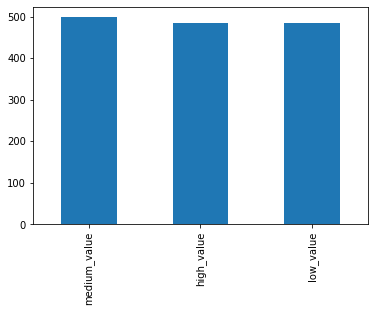

In [43]:
clv_final.LMH.value_counts().plot(kind='bar')
#Balanced Proportion of Low, Medium, High for Mutinomial-Classification!

In [44]:
#Assigning the Dependent Variable to Numeric Value!
dim={'low_value':0,'medium_value':1,'high_value':2}

In [46]:
clv_final['m_lmh']=clv_final['LMH'].map(dim)

#### b]Performing Classification Model.

In [47]:
#Nominal columns for Getting Dummy Variables!
nomcol=['Location','Gender']

In [48]:
clv_final1=pd.get_dummies(clv_final,columns = nomcol, drop_first = True)

In [49]:
#As we have the classification of LMH based on Monetary Value we no longer need that two Variables!
clv_final1.drop(['LMH','revenue_monetary'],axis=1,inplace=True)

##### Features based on Co-Relation

In [65]:
clv_final1.corrwith(clv_final1['m_lmh']).abs().sort_values(ascending = False).head(16)

m_lmh                  1.000000
no_product_sku         0.624586
Nest-USA               0.597279
no_of_transactions     0.554010
coupons_used           0.537426
avg_deliver_charges    0.460487
quantity_purchased     0.448820
Nest                   0.400433
Office                 0.391795
Apparel                0.333667
Drinkware              0.281292
Lifestyle              0.269120
rev_Nov                0.262494
Nest-Canada            0.257606
rev_Oct                0.243198
rev_Jul                0.239173
dtype: float64

In [66]:
imp_vars_cor=['no_of_transactions','avg_deliver_charges','quantity_purchased','no_product_sku',
              'Nest-USA','Nest','Office','Apparel','Drinkware','coupons_used','Lifestyle',
              'rev_Nov','Nest-Canada','rev_Oct','rev_Jul']

##### RFE

In [56]:
x=clv_final1[clv_final1.columns.difference(['m_lmh'])]

,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,Gender_M,Gift Cards,...,rev_Dec,rev_Feb,rev_Jan,rev_Jul,rev_Jun,rev_Mar,rev_May,rev_Nov,rev_Oct,rev_Sep
CustomerID,,,,,,,,,,,,,,,,,,,,,
17850,0.0,0.0,94.0,1.0,98.0,1.0,109.0,6.0,1,0.0,...,0.000,0.0,31110.858,0.0,0.0,0.000,0.0,0.0,0.0,0.0
13047,0.0,0.0,20.0,0.0,0.0,0.0,5.0,0.0,1,0.0,...,1477.798,0.0,839.781,0.0,0.0,0.000,0.0,0.0,0.0,0.0
12583,0.0,0.0,25.0,0.0,8.0,0.0,77.0,0.0,1,0.0,...,0.000,0.0,739.512,0.0,0.0,0.000,0.0,0.0,0.0,0.0
13748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.000,0.0,1.116,0.0,0.0,0.000,0.0,0.0,0.0,0.0
15100,0.0,0.0,1.0,0.0,2.0,0.0,5.0,0.0,1,0.0,...,0.000,0.0,138.339,0.0,521.5,91.665,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14438,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,0.0,...,354.816,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0
12956,0.0,0.0,8.0,0.0,0.0,0.0,1.0,0.0,0,0.0,...,2101.407,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0
15781,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1,0.0,...,514.703,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0


In [57]:
y=clv_final1.m_lmh

CustomerID
17850    2
13047    1
12583    1
13748    0
15100    1
        ..
14438    0
12956    1
15781    0
14410    1
14600    0
Name: m_lmh, Length: 1468, dtype: int64

In [67]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=15).fit(x,y)

In [68]:
imp_vars_RFE = list(x.columns[rfe.support_])
imp_vars_RFE

['Apparel',
 'Drinkware',
 'Lifestyle',
 'Nest',
 'Nest-USA',
 'Office',
 'Tenure_Months',
 'avg_deliver_charges',
 'coupons_used',
 'no_of_transactions',
 'no_product_sku',
 'quantity_purchased',
 'rev_Jan',
 'rev_Nov',
 'rev_Oct']

##### SelectKBest

In [69]:
SKB = SelectKBest(f_classif, k=15).fit(x,y)

In [70]:
imp_vars_kbest = list(x.columns[SKB.get_support()])
imp_vars_kbest

['Apparel',
 'Drinkware',
 'Lifestyle',
 'Nest',
 'Nest-Canada',
 'Nest-USA',
 'Office',
 'avg_deliver_charges',
 'coupons_used',
 'no_of_transactions',
 'no_product_sku',
 'quantity_purchased',
 'rev_Jul',
 'rev_Nov',
 'rev_Oct']

In [71]:
final_vars=list(set(imp_vars_cor + imp_vars_kbest + imp_vars_RFE))
final_vars

['rev_Oct',
 'quantity_purchased',
 'Nest',
 'Office',
 'rev_Nov',
 'Drinkware',
 'coupons_used',
 'Lifestyle',
 'rev_Jul',
 'Nest-Canada',
 'rev_Jan',
 'no_product_sku',
 'Tenure_Months',
 'Nest-USA',
 'Apparel',
 'no_of_transactions',
 'avg_deliver_charges']

In [72]:
#VIF
feature=final_vars
a=np.inf
while a>=5:
    vif=[variance_inflation_factor(clv_final1[feature].values,i) for i in range(clv_final1[feature].shape[1])]
    vif=pd.Series(vif,name='VIF')
    fet=pd.Series(clv_final1[feature].columns,name='Feature')
    vifdf=pd.concat([vif,fet],axis=1).sort_values(by="VIF")
    a=vifdf['VIF'].max()
    if a<=5:
        break
    feature=list(vifdf[:-1]["Feature"])
feature

['Nest-Canada',
 'rev_Jan',
 'Tenure_Months',
 'rev_Oct',
 'rev_Jul',
 'Lifestyle',
 'rev_Nov',
 'Office',
 'Drinkware',
 'Nest',
 'Apparel',
 'avg_deliver_charges']

In [74]:
#X vars after VIF!
x1=clv_final1[feature]

In [75]:
#Train and Test Split!
train_x,test_x,train_y,test_y=train_test_split(x1,y, test_size=0.3, random_state=123)

In [76]:
logreg =LogisticRegression()

In [77]:
logreg.fit(train_x,train_y)

LogisticRegression()

In [78]:
print(metrics.classification_report(train_y, logreg.predict(train_x)))
print(metrics.classification_report(test_y, logreg.predict(test_x)))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       331
           1       0.60      0.57      0.59       367
           2       0.69      0.79      0.74       329

    accuracy                           0.69      1027
   macro avg       0.69      0.69      0.69      1027
weighted avg       0.69      0.69      0.69      1027

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       154
           1       0.49      0.54      0.51       131
           2       0.74      0.81      0.77       156

    accuracy                           0.67       441
   macro avg       0.67      0.67      0.67       441
weighted avg       0.68      0.67      0.68       441



#### XGBoost Classifier

In [81]:
#Setting up Parm_grid for Grid SearchCV to get best params!
param_grid1 = {'learning_rate' : [0.01, 0.05, 0.1],'n_estimators' : [100,200,300],'max_depth' : [2,3,4]}

In [82]:
xgcv1 = GridSearchCV(XGBClassifier(), param_grid1, cv=5,verbose=True)

In [83]:
xgcv1.fit(train_x,train_y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 200, 300]},
             verbose=True)

In [84]:
xgcv1.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}

In [85]:
xgb = XGBClassifier(learning_rate= 0.01, max_depth= 4, n_estimators= 300).fit(train_x, train_y)

In [86]:
print(metrics.classification_report(train_y,xgb.predict(train_x)))
print(metrics.classification_report(test_y,xgb.predict(test_x)))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       331
           1       0.79      0.81      0.80       367
           2       0.90      0.90      0.90       329

    accuracy                           0.86      1027
   macro avg       0.86      0.86      0.86      1027
weighted avg       0.86      0.86      0.86      1027

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       154
           1       0.60      0.70      0.65       131
           2       0.90      0.85      0.87       156

    accuracy                           0.77       441
   macro avg       0.77      0.77      0.77       441
weighted avg       0.78      0.77      0.78       441



#### KNN Classifier

In [87]:
#Setting up Grid for KNN!
grid = {'n_neighbors':[3,5,7,9,11,13,15,17,18,19,20], 'weights' : ['uniform','distance']}

In [90]:
#GridSearchCv Function to get Best Params!
knn_model_cv = GridSearchCV(KNeighborsClassifier(),param_grid = grid, cv = 5, scoring='accuracy', verbose=True)

In [91]:
knn_model_cv.fit(train_x, train_y)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 18, 19,
                                         20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=True)

In [92]:
knn_model_cv.best_params_

{'n_neighbors': 13, 'weights': 'uniform'}

In [93]:
#Setting up Model with Best Params!
knn=KNeighborsClassifier(n_neighbors=13,weights='uniform')

In [94]:
#Fitting the Model!
knn.fit(train_x, train_y)

KNeighborsClassifier(n_neighbors=13)

In [95]:
print(metrics.classification_report(train_y, knn.predict(train_x)))
print(metrics.classification_report(test_y, knn.predict(test_x)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       331
           1       0.71      0.75      0.73       367
           2       0.86      0.79      0.82       329

    accuracy                           0.80      1027
   macro avg       0.80      0.80      0.80      1027
weighted avg       0.80      0.80      0.80      1027

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       154
           1       0.59      0.76      0.66       131
           2       0.94      0.76      0.84       156

    accuracy                           0.77       441
   macro avg       0.79      0.77      0.77       441
weighted avg       0.80      0.77      0.78       441



#### GradientBossting Classifier

In [97]:
pargrid_gbm = {'n_estimators': [100, 200, 400, 600, 800],'learning_rate': [10 ** x for x in range(-3, 3)], 'max_features' : [2,3,4]}

In [99]:
gscv_gbm = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=pargrid_gbm, cv=5,verbose=True, n_jobs=-1)

In [100]:
gscv_gbm.fit(train_x, train_y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_features': [2, 3, 4],
                         'n_estimators': [100, 200, 400, 600, 800]},
             verbose=True)

In [101]:
gscv_gbm.best_params_

{'learning_rate': 0.1, 'max_features': 2, 'n_estimators': 800}

In [103]:
gbm=GradientBoostingClassifier(learning_rate = 0.1, n_estimators=800,max_features=2)
gbm.fit(train_x, train_y)

GradientBoostingClassifier(max_features=2, n_estimators=800)

In [104]:
print(metrics.classification_report(train_y, gbm.predict(train_x)))
print(metrics.classification_report(test_y, gbm.predict(test_x)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       367
           2       1.00      1.00      1.00       329

    accuracy                           1.00      1027
   macro avg       1.00      1.00      1.00      1027
weighted avg       1.00      1.00      1.00      1027

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       154
           1       0.65      0.76      0.70       131
           2       0.90      0.87      0.88       156

    accuracy                           0.80       441
   macro avg       0.81      0.80      0.80       441
weighted avg       0.82      0.80      0.81       441



### Predicting Next Purchase Day(How soon each customer can visit the store(0-30 days,30-60 days,60-90 days,90+ days)


In [114]:
pur_day=cust_data2.copy()

In [143]:
tenure=tenure=(df_final.groupby('CustomerID')['Transaction_Date'].max().values.astype('datetime64[D]')-df_final.groupby('CustomerID')['Transaction_Date'].min().values.astype('datetime64[D]')).astype('int')
tenure

array([  0, 223, 119, ...,  76,   0,  73])

In [167]:
avg_days_per_trans=(tenure/pur_day1.no_of_transactions_x).round(0)
avg_days_per_trans

CustomerID
17850     0.0
13047     5.0
12583     3.0
13748     0.0
15100     0.0
         ... 
14438     0.0
12956     6.0
15781    15.0
14410     0.0
14600    36.0
Name: no_of_transactions_x, Length: 1468, dtype: float64

In [168]:
pur_day1=pd.merge(left=pur_day,right=avg_days_per_trans,on='CustomerID',how='inner').set_index('CustomerID')

In [170]:
pur_day1.rename(columns = {'no_of_transactions_x':'avg_days_per_trans'},inplace=True)

In [171]:
pur_day1


,Gender,Location,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,avg_days_per_trans
CustomerID,,,,,,,,
17850,M,Chicago,12,297,1133,3162.62,31110.858,0.0
13047,M,California,43,44,175,315.96,2321.227,5.0
12583,M,Chicago,33,42,155,757.27,1971.352,3.0
13748,F,California,30,1,1,6.50,1.116,0.0
15100,M,California,49,6,15,64.38,762.752,0.0
...,...,...,...,...,...,...,...,...
14438,F,New York,41,9,29,55.50,354.816,0.0
12956,F,Chicago,48,19,35,135.99,2101.407,6.0
15781,M,New Jersey,19,5,10,32.50,514.703,15.0


In [176]:
pur_day_final=pd.merge(left=pur_day1,right=pd.concat([ps_cu,rpm_qp],axis=1),on='CustomerID',how='inner')
pur_day_final

,Gender,Location,Tenure_Months,no_of_transactions,quantity_purchased,avg_deliver_charges,revenue_monetary,avg_days_per_trans,no_product_sku,coupons_used,...,Headgear,Housewares,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze
CustomerID,,,,,,,,,,,,,,,,,,,,,
17850,M,Chicago,12,297,1133,3162.62,31110.858,0.0,119,91,...,16.0,15.0,171.0,0.0,0.0,7.0,181.0,1.0,422.0,10.0
13047,M,California,43,44,175,315.96,2321.227,5.0,33,18,...,7.0,0.0,1.0,0.0,2.0,0.0,16.0,0.0,123.0,1.0
12583,M,Chicago,33,42,155,757.27,1971.352,3.0,40,12,...,1.0,3.0,1.0,0.0,0.0,0.0,10.0,26.0,4.0,0.0
13748,F,California,30,1,1,6.50,1.116,0.0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15100,M,California,49,6,15,64.38,762.752,0.0,5,2,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14438,F,New York,41,9,29,55.50,354.816,0.0,9,5,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,20.0,0.0
12956,F,Chicago,48,19,35,135.99,2101.407,6.0,12,5,...,0.0,0.0,0.0,0.0,4.0,0.0,19.0,0.0,3.0,0.0
15781,M,New Jersey,19,5,10,32.50,514.703,15.0,4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0


In [177]:
#Defining Purchase Bucket!
pur_day_final['purchase_bucket']=np.where(pur_day_final.avg_days_per_trans<=30, '0-30_days', np.where(pur_day_final.avg_days_per_trans<=60,'30-60_days', 
                                                            np.where(pur_day_final.avg_days_per_trans<=90,'60-90_days','90+_days')))

In [178]:
pur_day_final['purchase_bucket'].value_counts()

0-30_days     1394
30-60_days      40
90+_days        18
60-90_days      16
Name: purchase_bucket, dtype: int64

#### Mutinomial Classification Model

In [181]:
#Assigning the Dependent Variable to Numeric Value!
dim1={'0-30_days':0,'30-60_days':1,'60-90_days':2,'90+_days':3}

In [183]:
pur_day_final['m_pb1']=pur_day_final['purchase_bucket'].map(dim1)

In [185]:
nomcol1=['Location','Gender']

In [186]:
pur_day_final1=pd.get_dummies(pur_day_final,columns = nomcol1, drop_first = True)

In [193]:
pur_day_final1.drop(['no_of_transactions','avg_days_per_trans','revenue_monetary','purchase_bucket'],axis=1,inplace=True)

In [194]:
x_os=pur_day_final1[pur_day_final1.columns.difference(['m_pb1'])]

In [197]:
y_os=pur_day_final1.m_pb1

In [179]:
from imblearn.over_sampling import SMOTE

In [180]:
oversampling=SMOTE(sampling_strategy='auto',random_state=121,k_neighbors=4,n_jobs=-1)

In [200]:
f_x,f_y = oversampling.fit_resample(x_os,y_os)

In [201]:
f_y.value_counts()
#Now the Dependent Variable is Balanced!

0    1394
3    1394
1    1394
2    1394
Name: m_pb1, dtype: int64

#### Feature Engineering

In [207]:
df_1=pd.concat([f_x,f_y],axis=1)
df_1

,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,Gender_M,Gift Cards,...,rev_Feb,rev_Jan,rev_Jul,rev_Jun,rev_Mar,rev_May,rev_Nov,rev_Oct,rev_Sep,m_pb1
0,0.0,0.0,94.000000,1.0,98.00000,1.0,109.0,6.0,1,0.0,...,0.0,31110.858000,0.0,0.0,0.000,0.0,0.0,0.0,0.00000,0
1,0.0,0.0,20.000000,0.0,0.00000,0.0,5.0,0.0,1,0.0,...,0.0,839.781000,0.0,0.0,0.000,0.0,0.0,0.0,0.00000,0
2,0.0,0.0,25.000000,0.0,8.00000,0.0,77.0,0.0,1,0.0,...,0.0,739.512000,0.0,0.0,0.000,0.0,0.0,0.0,0.00000,0
3,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0,0.0,...,0.0,1.116000,0.0,0.0,0.000,0.0,0.0,0.0,0.00000,0
4,0.0,0.0,1.000000,0.0,2.00000,0.0,5.0,0.0,1,0.0,...,0.0,138.339000,0.0,521.5,91.665,0.0,0.0,0.0,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571,0.0,0.0,0.105695,0.0,0.00000,0.0,0.0,0.0,0,0.0,...,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.00000,3
5572,0.0,0.0,0.362507,0.0,0.00000,0.0,0.0,0.0,0,0.0,...,0.0,6.391352,0.0,0.0,0.000,0.0,0.0,0.0,0.70953,3
5573,0.0,0.0,1.512743,0.0,0.00000,0.0,0.0,0.0,0,0.0,...,0.0,7.459417,0.0,0.0,0.000,0.0,0.0,0.0,0.00000,3
5574,0.0,0.0,0.000000,0.0,2.86968,0.0,0.0,0.0,0,0.0,...,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.00000,3


In [223]:
#Univariate Regression!
df_1.corrwith(df_1['m_pb1']).abs().sort_values(ascending = False).head(16)

m_pb1                  1.000000
no_product_sku         0.504259
Nest-USA               0.412673
coupons_used           0.409264
avg_deliver_charges    0.352151
Gender_M               0.334200
quantity_purchased     0.324834
Office                 0.282637
Location_New York      0.282366
Nest                   0.279248
Apparel                0.256006
Lifestyle              0.227649
Drinkware              0.218282
Nest-Canada            0.205218
rev_Aug                0.190037
rev_Jun                0.189014
dtype: float64

In [224]:
imp_var_cor1=['no_product_sku', 'Nest-USA', 'coupons_used',
             'avg_deliver_charges', 'Gender_M', 'quantity_purchased', 'Office',
             'Location_New York', 'Nest', 'Apparel', 'Lifestyle', 'Drinkware',
             'Nest-Canada', 'rev_Aug', 'rev_Jun']

##### RFE

In [225]:
rfe1 = RFE(RandomForestClassifier(), n_features_to_select=15).fit(f_x,f_y)

In [226]:
imp_vars_rfe1 = list(f_x.columns[rfe1.support_])
imp_vars_rfe1

['Apparel',
 'Drinkware',
 'Lifestyle',
 'Nest-USA',
 'Office',
 'Tenure_Months',
 'avg_deliver_charges',
 'coupons_used',
 'no_product_sku',
 'quantity_purchased',
 'rev_Apr',
 'rev_Aug',
 'rev_Jan',
 'rev_Jul',
 'rev_Jun']

#### SKB

In [229]:
SKB1 = SelectKBest(f_classif, k=15).fit(f_x,f_y)

In [230]:
imp_vars_kbest1 = list(f_x.columns[SKB1.get_support()])
imp_vars_kbest1

['Apparel',
 'Drinkware',
 'Gender_M',
 'Lifestyle',
 'Location_New York',
 'Nest',
 'Nest-USA',
 'Office',
 'Tenure_Months',
 'avg_deliver_charges',
 'coupons_used',
 'no_product_sku',
 'quantity_purchased',
 'rev_Aug',
 'rev_Jun']

In [232]:
final_vars1=list(set( imp_var_cor1+imp_vars_kbest1 + imp_vars_rfe1))
final_vars1

['Office',
 'Nest',
 'Apparel',
 'Location_New York',
 'quantity_purchased',
 'Lifestyle',
 'Nest-USA',
 'avg_deliver_charges',
 'rev_Apr',
 'no_product_sku',
 'rev_Aug',
 'coupons_used',
 'Drinkware',
 'rev_Jul',
 'rev_Jan',
 'rev_Jun',
 'Tenure_Months',
 'Gender_M',
 'Nest-Canada']

In [233]:
#VIF
feature1=final_vars1
a=np.inf
while a>=5:
    vif=[variance_inflation_factor(df_1[feature1].values,i) for i in range(df_1[feature1].shape[1])]
    vif=pd.Series(vif,name='VIF')
    fet=pd.Series(df_1[feature1].columns,name='Feature')
    vifdf=pd.concat([vif,fet],axis=1).sort_values(by="VIF")
    a=vifdf['VIF'].max()
    if a<=5:
        break
    feature1=list(vifdf[:-1]["Feature"])
feature1

['Location_New York',
 'rev_Aug',
 'Gender_M',
 'Nest-Canada',
 'rev_Jun',
 'Tenure_Months',
 'rev_Jan',
 'rev_Jul',
 'Lifestyle',
 'rev_Apr',
 'Nest',
 'Office',
 'Drinkware',
 'Apparel',
 'avg_deliver_charges']

In [235]:
#X vars after VIF for training the model!
x_pd=df_1[feature1]

In [237]:
#Train and Test Split!
train_x_pd,test_x_pd,train_y_pd,test_y_pd=train_test_split(x_pd,f_y, test_size=0.3, random_state=123)

In [238]:
logreg =LogisticRegression()

In [239]:
logreg.fit(train_x_pd,train_y_pd)

LogisticRegression()

In [240]:
print(metrics.classification_report(train_y_pd, logreg.predict(train_x_pd)))
print(metrics.classification_report(test_y_pd, logreg.predict(test_x_pd)))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       981
           1       0.65      0.59      0.62       980
           2       0.64      0.51      0.56       981
           3       0.67      0.82      0.74       961

    accuracy                           0.69      3903
   macro avg       0.68      0.69      0.68      3903
weighted avg       0.68      0.69      0.68      3903

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       413
           1       0.61      0.55      0.58       414
           2       0.63      0.49      0.55       413
           3       0.66      0.82      0.73       433

    accuracy                           0.66      1673
   macro avg       0.66      0.66      0.66      1673
weighted avg       0.66      0.66      0.66      1673



#### RandomForest Classifier

In [241]:
#Setting up grid!
pargrid_rf = {'n_estimators': [50, 60, 70, 80, 90, 100],'max_features': [2,3,4],'max_depth': [2,3,4,5,6]}

In [242]:
#GridSearchCV to get Best Params for RandomForest Classifier!
gscv_rf = GridSearchCV(estimator=RandomForestClassifier(),param_grid=pargrid_rf,cv=5,
                        verbose=True, n_jobs=-1, scoring='accuracy')

In [243]:
gscv_rf.fit(train_x_pd,train_y_pd)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'max_features': [2, 3, 4],
                         'n_estimators': [50, 60, 70, 80, 90, 100]},
             scoring='accuracy', verbose=True)

In [244]:
gscv_rf.best_params_

{'max_depth': 6, 'max_features': 4, 'n_estimators': 70}

In [245]:
#Setting up model with Best Params!
rf_cf=RandomForestClassifier(n_estimators=70,max_depth=6,max_features=4)

In [246]:
#Fitting the Model!
rf_cf.fit(train_x_pd,train_y_pd)

RandomForestClassifier(max_depth=6, max_features=4, n_estimators=70)

In [247]:
print(metrics.classification_report(train_y_pd, rf_cf.predict(train_x_pd)))
print(metrics.classification_report(test_y_pd, rf_cf.predict(test_x_pd)))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       981
           1       0.94      0.98      0.96       980
           2       0.97      0.99      0.98       981
           3       0.95      1.00      0.98       961

    accuracy                           0.96      3903
   macro avg       0.96      0.96      0.96      3903
weighted avg       0.96      0.96      0.96      3903

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       413
           1       0.92      0.96      0.94       414
           2       0.93      0.97      0.95       413
           3       0.94      0.99      0.96       433

    accuracy                           0.94      1673
   macro avg       0.94      0.94      0.94      1673
weighted avg       0.94      0.94      0.94      1673



#### XGBoost Classifier

In [248]:
#Setting up Parm_grid for Grid SearchCV to get best params!
param_grid1 = {'learning_rate' : [0.01, 0.05, 0.1],'n_estimators' : [100,200,300],'max_depth' : [2,3,4]}

In [249]:
xgcv1 = GridSearchCV(XGBClassifier(), param_grid1, cv=5,verbose=True)

In [250]:
xgcv1.fit(train_x_pd,train_y_pd)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 200, 300]},
             verbose=True)

In [251]:
xgcv1.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

In [252]:
xgb1=XGBClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 300)

In [253]:
xgb1.fit(train_x_pd,train_y_pd)

XGBClassifier(n_estimators=300, objective='multi:softprob')

In [254]:
print(metrics.classification_report(train_y_pd, xgb1.predict(train_x_pd)))
print(metrics.classification_report(test_y_pd, xgb1.predict(test_x_pd)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       981
           1       0.99      1.00      1.00       980
           2       1.00      1.00      1.00       981
           3       1.00      1.00      1.00       961

    accuracy                           1.00      3903
   macro avg       1.00      1.00      1.00      3903
weighted avg       1.00      1.00      1.00      3903

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       413
           1       0.97      0.97      0.97       414
           2       0.97      1.00      0.99       413
           3       0.99      0.99      0.99       433

    accuracy                           0.98      1673
   macro avg       0.98      0.98      0.98      1673
weighted avg       0.98      0.98      0.98      1673

